In [1]:
from GenZ import decode_moddeling, prefill_moddeling

from GenZ.system import System
import pandas as pd
from GenZ.analyse_model import get_model_df, get_summary_table

from GenZ import create_inference_mamba_prefix_model, create_inference_mamba_decode_model

In [2]:
# This will reload the imported modules (e.g. get_decode_model_characterstics) every time you execute the jupyter cells, so that you don't need to restart the notebook after updating the source codes.
%load_ext autoreload
%autoreload 2   

In [3]:
system = System(frequency=1000 , flops=2000, off_chip_mem_size=(80*1024), compute_efficiency=0.8, memory_efficiency=0.8,
                     offchip_mem_bw=3500, bits='int8', external_mem_bw=128, interchip_mem_bw=256, interchip_link_latency=2)

In [4]:
################################################################################################## #
### Model Characterization Calculation
################################################################################################## #
model_prefill = create_inference_mamba_prefix_model(input_sequence_length=10,output_gen_tokens = 0 ,
                                    name='tiiuae/falcon-mamba-7b')

B = 1
model_df = get_model_df(model_prefill, system, batch_size=B,  model_characterstics = True)
summary_table = get_summary_table(model_df, model_characterstics = True)


In [5]:
display(model_df)
display(summary_table)

,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB)
0,GEMM,"[((1, 4096, 10), (131072, 4096), (1, 131072, 1...",9.974886,5368.70912,0.039062,512.0,1.25,513.289062
1,CONV1D,"((1, 10, 65536), (65536, 1, 4), (1, 10, 65536))",1.666667,2.62144,0.625,0.25,0.625,1.5
2,GEMM,"[((1, 65536, 10), (288, 65536), (1, 288, 10))]",9.663005,188.74368,0.625,18.0,0.002747,18.627747
3,GEMM,"[((1, 256, 10), (65536, 256), (1, 65536, 10))]",9.622647,167.77216,0.002441,16.0,0.625,16.627441
4,Einsum,"([1, 65536, 10], [65536, 16], [1, 65536, 10, 16])",0.860215,10.48576,0.625,1.0,10.0,11.625
5,Einsum,"([1, 65536, 10], [1, 10, 16], [1, 65536, 10, 16])",0.941163,10.48576,0.625,0.000153,10.0,10.625153
6,Einsum,"([1, 65536, 10, 16], [1, 65536, 10], [1, 65536...",0.484848,10.48576,10.0,0.625,10.0,20.625
7,Einsum,"([10, 1, 65536, 16], [10, 1, 65536, 16], [10, ...",0.333333,10.48576,10.0,10.0,10.0,30.0
8,Einsum,"([10, 1, 65536, 16], [10, 1, 16], [10, 1, 65536])",0.941163,10.48576,10.0,0.000153,0.625,10.625153
9,Einsum,"([1, 10, 65536], [1, 10, 65536], [1, 10, 65536])",0.333333,0.65536,0.625,0.625,0.625,1.875


,MACs (MFLOP),Total Data (MB),Total Weights (MB),Parameters (MB),On-chip Memory Footprint (MB)
0,9472.57344,990.271118,911.125305,911.125305,513.289062


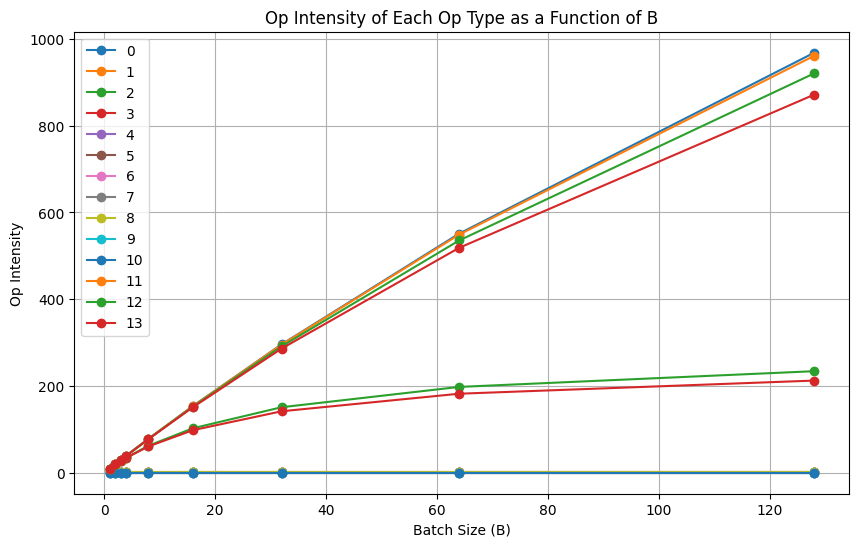

In [6]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store Op Intensity for each Op Type
op_intensity_data = {op_idx: [] for op_idx in range(len(model_df))}

# Vary B from 1 to 128
batch_sizes = [1,2,3,4,8,16,32,64,128]
for B in batch_sizes:
    model_df = get_model_df(model_prefill, system, batch_size=B, model_characterstics=True)
    for op_idx in range(len(model_df)):
        subset = model_df.loc[op_idx]
        op_intensity_data[op_idx].append(subset['Op Intensity'])

# Plotting
plt.figure(figsize=(10, 6))
for op_type, intensities in op_intensity_data.items():
    plt.plot(batch_sizes, intensities, marker='o', linestyle='-', label=op_type)

plt.xlabel('Batch Size (B)')
plt.ylabel('Op Intensity')
plt.title('Op Intensity of Each Op Type as a Function of B')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
################################################################################################## #
### Model Characterization Calculation
################################################################################################## #
model_decode = create_inference_mamba_decode_model(input_sequence_length=10000,output_gen_tokens = 0 ,
                                    name='tiiuae/falcon-mamba-7b')

B = 1
model_df = get_model_df(model_decode, system, batch_size=B,  model_characterstics = True)
summary_table = get_summary_table(model_df, model_characterstics = True)


In [8]:
display(model_df)
display(summary_table)

,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB)
0,GEMM,"[((1, 4096, 1), (131072, 4096), (1, 131072, 1))]",0.999748,536.870912,0.003906,512.0,0.125,512.128906
1,CONV1D,"((1, 1, 65536), (65536, 1, 4), (1, 1, 65536))",0.666667,0.262144,0.0625,0.25,0.0625,0.375
2,GEMM,"[((1, 65536, 1), (288, 65536), (1, 288, 1))]",0.996525,18.874368,0.0625,18.0,0.000275,18.062775
3,GEMM,"[((1, 256, 1), (65536, 256), (1, 65536, 1))]",0.996094,16.777216,0.000244,16.0,0.0625,16.062744
4,Einsum,"([1, 65536, 1], [65536, 16], [1, 65536, 1, 16])",0.484848,1.048576,0.0625,1.0,1.0,2.0625
5,Einsum,"([1, 65536, 1], [1, 1, 16], [1, 65536, 1, 16])",0.941163,1.048576,0.0625,0.000015,1.0,1.062515
6,Einsum,"([1, 65536, 1, 16], [1, 65536, 1], [1, 65536, ...",0.484848,1.048576,1.0,0.0625,1.0,2.0625
7,Einsum,"([1, 1, 65536, 16], [1, 1, 65536, 16], [1, 1, ...",0.333333,1.048576,1.0,1.0,1.0,3.0
8,Einsum,"([1, 1, 65536, 16], [1, 1, 16], [1, 1, 65536])",0.941163,1.048576,1.0,0.000015,0.0625,1.062515
9,Einsum,"([1, 1, 65536], [1, 1, 65536], [1, 1, 65536])",0.333333,0.065536,0.0625,0.0625,0.0625,0.1875


,MACs (MFLOP),Total Data (MB),Total Weights (MB),Parameters (MB),On-chip Memory Footprint (MB)
0,947.257344,908.352112,900.437531,900.437531,512.128906


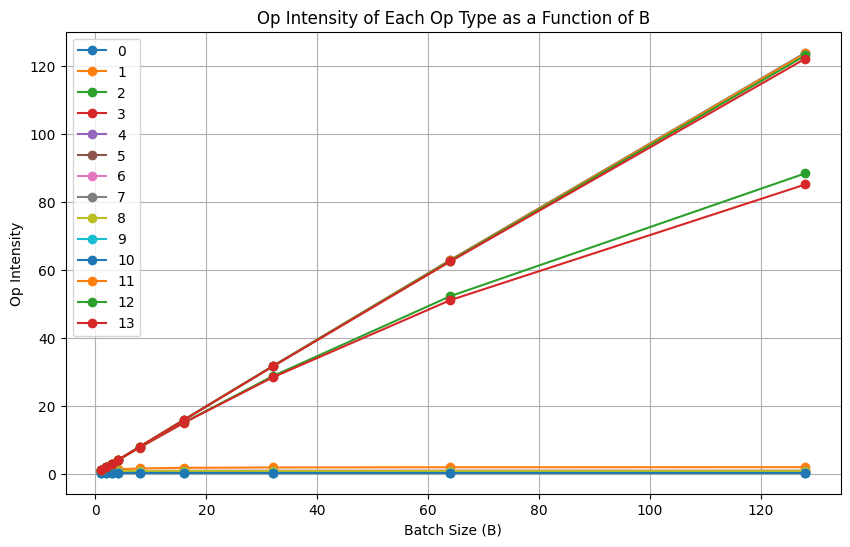

In [9]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store Op Intensity for each Op Type
op_intensity_data = {op_idx: [] for op_idx in range(len(model_df))}

# Vary B from 1 to 128
batch_sizes = [1,2,3,4,8,16,32,64,128]
for B in batch_sizes:
    model_df = get_model_df(model_decode, system, batch_size=B, model_characterstics=True)
    for op_idx in range(len(model_df)):
        subset = model_df.loc[op_idx]
        op_intensity_data[op_idx].append(subset['Op Intensity'])

# Plotting
plt.figure(figsize=(10, 6))
for op_type, intensities in op_intensity_data.items():
    plt.plot(batch_sizes, intensities, marker='o', linestyle='-', label=op_type)

plt.xlabel('Batch Size (B)')
plt.ylabel('Op Intensity')
plt.title('Op Intensity of Each Op Type as a Function of B')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
model_df

,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB)
0,GEMM,"[((128, 4096, 1), (131072, 4096), (128, 131072...",124.003784,68719.476736,0.5,512.0,16.0,528.5
1,CONV1D,"((128, 1, 65536), (65536, 1, 4), (128, 1, 65536))",1.969231,33.554432,8.0,0.25,8.0,16.25
2,GEMM,"[((128, 65536, 1), (288, 65536), (128, 288, 1))]",88.495724,2415.919104,8.0,18.0,0.035156,26.035156
3,GEMM,"[((128, 256, 1), (65536, 256), (128, 65536, 1))]",85.222367,2147.483648,0.03125,16.0,8.0,24.03125
4,Einsum,"([128, 65536, 1], [65536, 16], [128, 65536, 1,...",0.934307,134.217728,8.0,1.0,128.0,137.0
5,Einsum,"([128, 65536, 1], [128, 1, 16], [128, 65536, 1...",0.941163,134.217728,8.0,0.001953,128.0,136.001953
6,Einsum,"([128, 65536, 1, 16], [128, 65536, 1], [128, 6...",0.484848,134.217728,128.0,8.0,128.0,264.0
7,Einsum,"([1, 128, 65536, 16], [1, 128, 65536, 16], [1,...",0.333333,134.217728,128.0,128.0,128.0,384.0
8,Einsum,"([1, 128, 65536, 16], [1, 128, 16], [1, 128, 6...",0.941163,134.217728,128.0,0.001953,8.0,136.001953
9,Einsum,"([128, 1, 65536], [128, 1, 65536], [128, 1, 65...",0.333333,8.388608,8.0,8.0,8.0,24.0
